In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Ladda ner och förbereda MINST-dataset

In [4]:
mnist = fetch_openml('mnist_784', version = 1, cache = True, as_frame = False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

In [6]:
# Dela upp i träningsdata 80% och testdata 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## EDA

In [7]:
# Information om data
print("Form på datamängden (X):", X.shape)
print("Form på etiketterna (y):", y.shape)
print("Antal pixlar per bild:", X.shape[1])  # 784 = 28x28 pixlar
print("Unika siffror i datasetet:", np.unique(y))

Form på datamängden (X): (70000, 784)
Form på etiketterna (y): (70000,)
Antal pixlar per bild: 784
Unika siffror i datasetet: [0 1 2 3 4 5 6 7 8 9]


In [8]:
# Kontrollera saknade värden
print("Saknade värden i X:", np.isnan(X).sum())
print("Saknade värden i y:", np.isnan(y).sum())

Saknade värden i X: 0
Saknade värden i y: 0


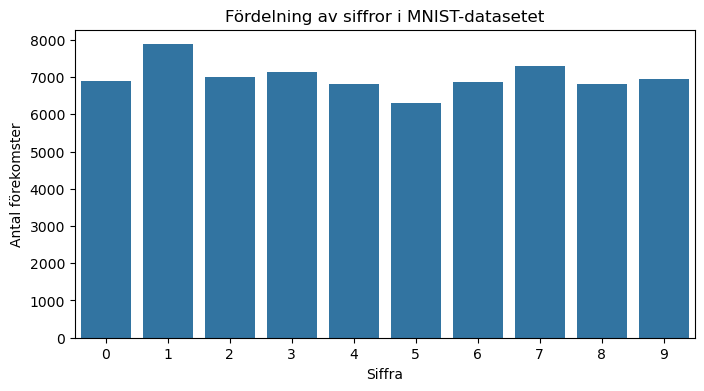

In [9]:
# Visualisera fördelning av siffror
plt.figure(figsize=(8, 4))
sns.countplot(x=y)
plt.title("Fördelning av siffror i MNIST-datasetet")
plt.xlabel("Siffra")
plt.ylabel("Antal förekomster")
plt.show()

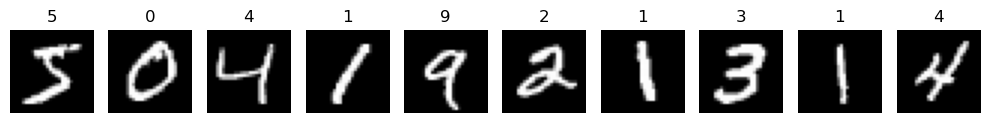

In [10]:
# Exempelbilder 
def visa_siffror(bilder, etiketter, antal=10):
    plt.figure(figsize=(10, 2))
    for i in range(antal):
        plt.subplot(1, antal, i + 1)
        plt.imshow(bilder[i].reshape(28, 28), cmap="gray")
        plt.title(f"{etiketter[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visa_siffror(X, y)

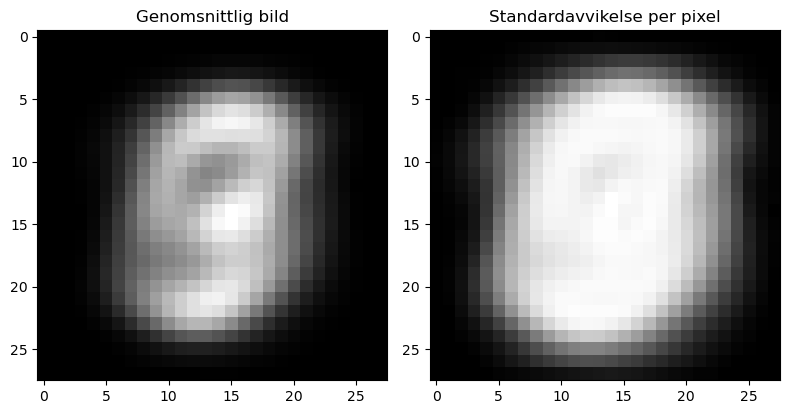

In [11]:
# Genomsnittsbild och standardavvikelse
medelbild = np.mean(X, axis=0).reshape(28, 28)
stdbild = np.std(X, axis=0).reshape(28, 28)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(medelbild, cmap="gray")
plt.title("Genomsnittlig bild")

plt.subplot(1, 2, 2)
plt.imshow(stdbild, cmap="gray")
plt.title("Standardavvikelse per pixel")

plt.tight_layout()
plt.show()

# Träna modeller

In [12]:
# Logistic Regression
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=100)), 
    ('clf', LogisticRegression (solver='lbfgs', multi_class='multinomial', max_iter=1000))
])

param_grid = {'clf__C': [0.1, 1, 2, 5]}

pipe_grid = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
)

pipe_grid.fit(X_train, y_train)

print(f"Best hyperparameters: {pipe_grid.best_params_}")
print(f"Validation score: {pipe_grid.best_score_:.4f}")

Best hyperparameters: {'clf__C': 0.1}
Validation score: 0.9172


In [13]:
# Random Forest
ran_for = RandomForestClassifier(random_state=42)  

ran_params = {                                
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    }

ran_grid = GridSearchCV(
    ran_for, 
    ran_params, 
    cv=3, 
    scoring='accuracy', 
)

ran_grid.fit(X_train, y_train)

print(f"Best hyperparameters: {ran_grid.best_params_}")
print(f"Validation score: {ran_grid.best_score_:.4f}") 

Best hyperparameters: {'max_depth': 30, 'n_estimators': 300}
Validation score: 0.9671


In [14]:
# Extra Trees
ext_tre = ExtraTreesClassifier(random_state=42)    

ext_params = {                                 
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}

ext_grid = GridSearchCV(
    ext_tre, 
    ext_params, 
    cv=3, 
    scoring='accuracy', 
)

ext_grid.fit(X_train, y_train)                

print(f"Best hyperparameters: {ext_grid.best_params_}")
print(f"Validation score: {ext_grid.best_score_:.4f}")

Best hyperparameters: {'max_depth': 30, 'n_estimators': 300}
Validation score: 0.9705


# Utvärdering på testdata

In [15]:
# Utvärderar bästa modell (Extra Trees)
pred_test = ext_grid.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9714


In [16]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1381
           1       0.99      0.99      0.99      1575
           2       0.97      0.97      0.97      1398
           3       0.97      0.96      0.97      1428
           4       0.98      0.96      0.97      1365
           5       0.97      0.97      0.97      1263
           6       0.97      0.99      0.98      1375
           7       0.97      0.97      0.97      1459
           8       0.97      0.96      0.96      1365
           9       0.94      0.95      0.95      1391

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



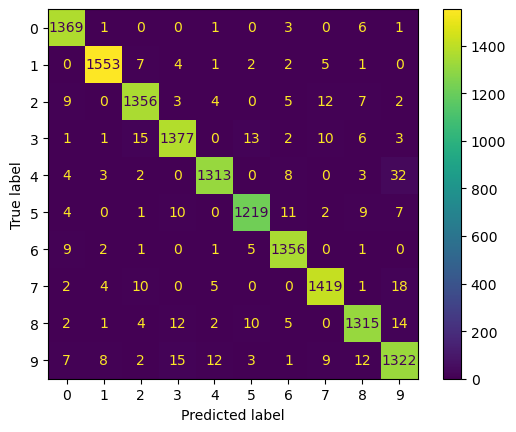

In [17]:
cm = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [19]:
import joblib

#sparar tränade modeller 
joblib.dump(pipe_grid, "log_reg.pkl")
joblib.dump(ran_grid, "ran_for.pkl")
joblib.dump(ext_grid, "ext_tre.pkl")

#sparar bästa modell
joblib.dump(ext_grid.best_estimator_, "best_model.pkl")

['best_model.pkl']